<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_Logistinen_Regressio_otsonipiikkien_ennustamiseen_(Baseline).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Logistic Regression Ozone Spike Prediction Script (Baseline) ---

Ladataan ozone dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Datan (ozone) käsittely valmis, muoto: (43180, 1)

Ladataan weather dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv
Datan (weather) käsittely valmis, muoto: (43463, 3)

Yhdistetään otsoni- ja säädata...
Yhdistämisen jälkeen rivejä (raw): 42803
Rivejä NaN-poiston jälkeen (raw): 42803
Uudelleenotanta ('resample') tunneittaiseen taajuuteen...
Rivejä resamplen jälkeen: 43848
Löytyi 4180 NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...
Datan yhdistäminen ja resample onnistui.

--- 3. Piikkien määrittely ---
Piikin kynnysarvo (90. persentiili): 77.10 µg/m³
Piikkejä löytyi: 4373 kpl (9.97 % datas

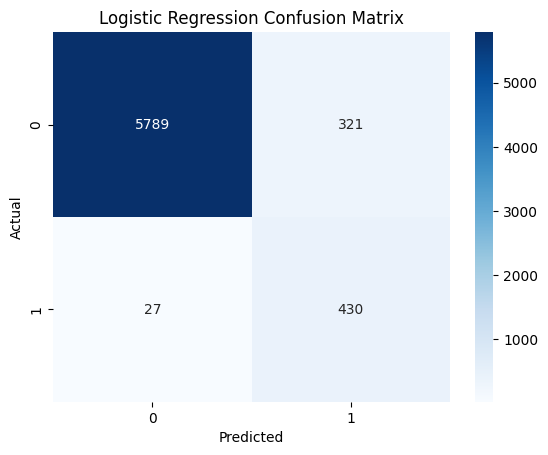

ROC AUC Score: 0.9877


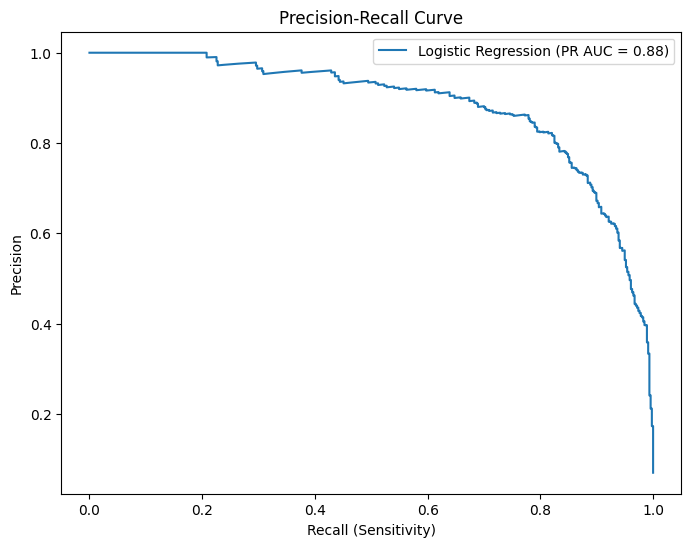


--- Logistinen Regressio -skripti päättyi ---


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script for Ozone Spike Prediction using Logistic Regression (Baseline)

Loads Kallio ozone and Kaisaniemi weather data, merges, resamples,
engineers time-series features (lags, time features, rolling stats),
defines spikes, trains a Logistic Regression classifier, and evaluates.
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

# Koneoppimiskirjastot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # Logistinen Regressio
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

print("--- Logistic Regression Ozone Spike Prediction Script (Baseline) ---")

# --- Funktiot datan lataamiseen ja peruspuhdistukseen ---
# (Sama kuin aiemmin v7/v8/v9)
def load_and_clean_data(raw_url, data_type='weather', cols_to_keep=None):
    """Lataa ja esikäsittelee datan, pitäen vain tarvittavat sarakkeet."""
    print(f"\nLadataan {data_type} dataa: {raw_url}")
    df_local = None
    try:
        response = requests.get(raw_url)
        response.raise_for_status()
        encoding = 'utf-8' if data_type == 'weather' else 'iso-8859-1'
        # print(f"Lukeminen CSV:stä (encoding={encoding})...")
        csv_content = io.StringIO(response.content.decode(encoding))

        if data_type == 'ozone':
             column_names_ozone = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
             df_local = pd.read_csv(
                  csv_content, sep=',', decimal=',', skiprows=1, header=None,
                  names=column_names_ozone, quoting=csv.QUOTE_NONNUMERIC, low_memory=False
             )
             target_col = "Otsoni [µg/m³]"
             if target_col in df_local.columns:
                  df_local[target_col] = pd.to_numeric(df_local[target_col], errors='coerce')
             else: raise ValueError(f"Otsonisarake '{target_col}' ei löytynyt.")

        elif data_type == 'weather':
            df_local = pd.read_csv(csv_content, sep=',', decimal='.', low_memory=False)
            df_local.columns = df_local.columns.str.strip()
            weather_cols_to_convert = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Tuulen suunnan keskiarvo [°]', 'Ilmanpaineen keskiarvo [hPa]']
            for col in weather_cols_to_convert:
                 if col in df_local.columns:
                      df_local[col] = pd.to_numeric(df_local[col], errors='coerce')

        else: raise ValueError(f"Tuntematon data_type: {data_type}")

        year_col, month_col, day_col, time_col = 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]'
        required_dt_cols = [year_col, month_col, day_col, time_col]
        if not all(col in df_local.columns for col in required_dt_cols):
            raise ValueError(f"Aikaleiman luontiin vaadittavia sarakkeita puuttuu: {required_dt_cols}")

        df_local[year_col] = pd.to_numeric(df_local[year_col], errors='coerce').astype('Int64')
        df_local[month_col] = pd.to_numeric(df_local[month_col], errors='coerce').astype('Int64')
        df_local[day_col] = pd.to_numeric(df_local[day_col], errors='coerce').astype('Int64')
        if df_local[required_dt_cols].isnull().any().any():
            df_local.dropna(subset=required_dt_cols, inplace=True)

        df_local[year_col] = df_local[year_col].astype(str)
        df_local[month_col] = df_local[month_col].astype(str).str.zfill(2)
        df_local[day_col] = df_local[day_col].astype(str).str.zfill(2)
        df_local[time_col] = df_local[time_col].astype(str)
        time_str = df_local[time_col].str.replace('24:00', '00:00', regex=False)
        datetime_str = df_local[year_col] + '-' + df_local[month_col] + '-' + df_local[day_col] + ' ' + time_str
        df_local['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df_local.loc[df_local[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)

        cols_to_select = ['Timestamp'] + (cols_to_keep if cols_to_keep else [])
        missing_cols = [col for col in cols_to_select if col not in df_local.columns]
        if missing_cols:
             raise ValueError(f"Vaadittuja sarakkeita puuttuu datasta: {missing_cols}")
        df_local = df_local[cols_to_select].copy()

        df_local.dropna(subset=['Timestamp'] + (cols_to_keep if cols_to_keep else []), inplace=True)

        df_local.set_index('Timestamp', inplace=True)
        df_local.sort_index(inplace=True)
        duplicates = df_local.index.duplicated(keep='first')
        if duplicates.sum() > 0:
            # print(f"Poistetaan {duplicates.sum()} duplikaatti-indeksiä.")
            df_local = df_local[~duplicates]

        print(f"Datan ({data_type}) käsittely valmis, muoto: {df_local.shape}")
        if df_local.empty: print(f"VAROITUS: {data_type} DataFrame on tyhjä!")
        return df_local

    except requests.exceptions.RequestException as e:
        print(f"Virhe datan haussa URL:sta ({data_type}): {e}")
        return None
    except Exception as e:
        print(f"Virhe datan käsittelyssä ({data_type}): {e}")
        traceback.print_exc()
        return None

# --- 1. Datan lataus ---
ozone_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
weather_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv"

o3_col = "Otsoni [µg/m³]"
weather_cols = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]'] # Otetaan myös tuulen suunta mukaan? 'Tuulen suunnan keskiarvo [°]'

df_ozone = load_and_clean_data(ozone_url, data_type='ozone', cols_to_keep=[o3_col])
df_weather = load_and_clean_data(weather_url, data_type='weather', cols_to_keep=weather_cols)

# --- 2. Datan yhdistäminen & RESAMPLE ---
df_merged = None
if df_ozone is not None and not df_ozone.empty and df_weather is not None and not df_weather.empty:
    print("\nYhdistetään otsoni- ja säädata...")
    df_merged_raw = pd.merge(df_ozone, df_weather, left_index=True, right_index=True, how='inner')
    print(f"Yhdistämisen jälkeen rivejä (raw): {len(df_merged_raw)}")
    df_merged_raw.dropna(inplace=True)
    print(f"Rivejä NaN-poiston jälkeen (raw): {len(df_merged_raw)}")

    if not df_merged_raw.empty:
        print("Uudelleenotanta ('resample') tunneittaiseen taajuuteen...")
        df_merged = df_merged_raw.resample('h').mean()
        print(f"Rivejä resamplen jälkeen: {len(df_merged)}")
        nan_after_resample = df_merged.isnull().sum().sum()
        if nan_after_resample > 0:
            print(f"Löytyi {nan_after_resample} NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...")
            df_merged.interpolate(method='time', inplace=True)
            remaining_nan = df_merged.isnull().sum().sum()
            if remaining_nan > 0:
                 print(f"Varoitus: Jäljellä {remaining_nan} NaN-arvoa interpoloinnin jälkeen. Täytetään (ffill/bfill)...")
                 df_merged.fillna(method='ffill', inplace=True)
                 df_merged.fillna(method='bfill', inplace=True)
        if df_merged.isnull().any().any():
             print("VAROITUS: NaN-arvoja jäi datan käsittelyn jälkeen! Poistetaan rivit.")
             df_merged.dropna(inplace=True)
        if df_merged.empty:
            print("Virhe: Data tyhjä resamplen/NaN-käsittelyn jälkeen.")
            df_merged = None
        else:
            print("Datan yhdistäminen ja resample onnistui.")
    else:
        print("Virhe: Yhdistetty data tyhjä ennen resamplea.")
        df_merged = None

# Jatka vain jos data ok
if df_merged is not None:

    # --- 3. Piikkien määrittely ---
    print("\n--- 3. Piikkien määrittely ---")
    spike_threshold = df_merged[o3_col].quantile(0.90)
    df_merged['onko_piikki'] = (df_merged[o3_col] > spike_threshold).astype(int)
    print(f"Piikin kynnysarvo ({0.90*100:.0f}. persentiili): {spike_threshold:.2f} µg/m³")
    print(f"Piikkejä löytyi: {df_merged['onko_piikki'].sum()} kpl ({df_merged['onko_piikki'].mean()*100:.2f} % datasta)")

    # --- 4. Piirteiden muokkaus (Feature Engineering) ---
    print("\n--- 4. Piirteiden muokkaus ---")

    # 4a. Aikaan perustuvat piirteet (sykliset)
    print("Luodaan aikaan perustuvia piirteitä...")
    seconds_in_day = 24 * 60 * 60
    seconds_in_year = 365.2425 * seconds_in_day

    df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged.index.hour / 24)
    df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged.index.hour / 24)
    df_merged['dayofweek_sin'] = np.sin(2 * np.pi * df_merged.index.dayofweek / 7)
    df_merged['dayofweek_cos'] = np.cos(2 * np.pi * df_merged.index.dayofweek / 7)
    df_merged['month_sin'] = np.sin(2 * np.pi * df_merged.index.month / 12)
    df_merged['month_cos'] = np.cos(2 * np.pi * df_merged.index.month / 12)
    # Voitaisiin lisätä myös dayofyear_sin/cos

    # 4b. Viiveistetyt piirteet (Lags)
    features_to_lag = [o3_col] + weather_cols
    lag_periods = [1, 2, 3, 6, 12, 24, 48, 72] # Laajempi setti viiveitä
    print(f"Luodaan viivepiirteet {lag_periods} tunnin jaksoilla...")
    for col in features_to_lag:
        for lag in lag_periods:
            df_merged[f'{col}_lag{lag}'] = df_merged[col].shift(lag)

    # 4c. Liukuvat keskiarvot/tilastot (Rolling features)
    rolling_window_hours = [3, 6, 12, 24, 48]
    print(f"Luodaan liukuvia tilastoja {rolling_window_hours} tunnin ikkunoilla...")
    for window in rolling_window_hours:
        shifted_o3 = df_merged[o3_col].shift(1) # Vältä nykyisen arvon käyttöä
        df_merged[f'{o3_col}_roll_mean_{window}h'] = shifted_o3.rolling(window=window).mean()
        df_merged[f'{o3_col}_roll_std_{window}h'] = shifted_o3.rolling(window=window).std()
        # Lisää tarvittaessa muille muuttujille

    # Poista NaN-arvot, jotka syntyivät piirteiden luonnista
    initial_rows = len(df_merged)
    df_merged.dropna(inplace=True)
    print(f"Poistettu {initial_rows - len(df_merged)} riviä piirteiden muokkauksen jälkeen.")

    if df_merged.empty:
         print("Virhe: Data tyhjä piirteiden muokkauksen jälkeen.")
         df_merged = None

if df_merged is not None:
    # --- 5. Datan jako opetus- ja testijoukkoihin ---
    print("\n--- 5. Datan jako opetus- ja testijoukkoihin ---")
    target = 'onko_piikki'
    # Poista alkuperäinen otsonipitoisuus piirteistä
    features = [col for col in df_merged.columns if col not in [o3_col, target]]

    X = df_merged[features]
    y = df_merged[target]

    # Ajallinen jako
    test_size = 0.15
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    print(f"Opetusdata: {X_train.index.min()} - {X_train.index.max()} ({len(X_train)} riviä)")
    print(f"Testidata: {X_test.index.min()} - {X_test.index.max()} ({len(X_test)} riviä)")
    print(f"Piikkejä opetusdatassa: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
    print(f"Piikkejä testidatassa: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

    # --- 6. Piirteiden skaalaus ---
    print("\n--- 6. Skaalataan piirteet ---")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Muunnetaan takaisin DataFrameksi sarakkeiden nimien säilyttämiseksi (hyvä käytäntö)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
    print("Skaalaus valmis.")

    # --- 7. Logistisen Regression mallin koulutus ja evaluointi ---
    print("\n--- 7. Logistisen Regression mallin koulutus ja evaluointi ---")

    try:
        # Alusta Logistinen Regressio -luokittelija
        # class_weight='balanced' auttaa epätasapainoisen datan kanssa
        log_reg_model = LogisticRegression(
            class_weight='balanced',
            random_state=42,
            solver='liblinear', # Hyvä pienemmille dataseteille tai binääriluokitteluun
            max_iter=200 # Lisätään iteraatioita varmuuden vuoksi
        )

        print("Koulutetaan Logistista Regressiota...")
        log_reg_model.fit(X_train_scaled, y_train)
        print("Malli koulutettu.")

        # Tee ennusteet testidatalle
        y_pred_logreg = log_reg_model.predict(X_test_scaled)
        y_pred_proba_logreg = log_reg_model.predict_proba(X_test_scaled)[:, 1] # Todennäköisyys piikille

        # Evaluoi luokittelija
        print("\nLogistisen Regression evaluointi:")
        print(classification_report(y_test, y_pred_logreg, zero_division=0))
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred_logreg)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Logistic Regression Confusion Matrix')
        plt.show()

        try:
             auc_score = roc_auc_score(y_test, y_pred_proba_logreg)
             print(f"ROC AUC Score: {auc_score:.4f}")
             # Piirrä Precision-Recall käyrä
             precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_logreg)
             pr_auc = auc(recall, precision)
             plt.figure(figsize=(8, 6))
             plt.plot(recall, precision, label=f'Logistic Regression (PR AUC = {pr_auc:.2f})')
             plt.xlabel('Recall (Sensitivity)')
             plt.ylabel('Precision')
             plt.title('Precision-Recall Curve')
             plt.legend()
             plt.show()

        except ValueError as ve_auc:
             print(f"Could not calculate ROC AUC / PR Curve: {ve_auc}")

        # Voitaisiin tarkastella myös kertoimia (coefficients), mutta niitä on paljon
        # coeff_df = pd.DataFrame(log_reg_model.coef_[0], index=X_train.columns, columns=['Coefficient'])
        # print("\nFeature Coefficients (Top/Bottom):")
        # print(coeff_df.abs().sort_values('Coefficient', ascending=False).head(15))


    except Exception as e_logreg:
        print(f"Virhe Logistisen Regression ajossa: {e_logreg}")
        traceback.print_exc()

else: # df_merged is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan yhdistäminen/muokkaus epäonnistui.")


print("\n--- Logistinen Regressio -skripti päättyi ---")